# Normalization

In [227]:
# import lib
import pandas as pd
import os
import matplotlib.pyplot as plt
import morton
import glob
import seaborn as sb
import numpy as np
import dtw
from time import time


In [185]:
m = morton.Morton(dimensions=2, bits=18)
def set_value(data,key1,key2):    
    return m.pack(round(data[key1]), round(data[key2]))

### Original Lane change

In [186]:
LaneChangeOriginalPath ="./Data/LaneChange/original/"
LaneChangeExtractPath ="./Data/LaneChange/extract/"


### Extract lane change - AOI

In [187]:
def load_All_LaneChange_In_Subfolder_Then_Select_With_Thresholds(inputFilePath,outputFilePath,key,ts_key,threshold1,threshold2,offset1=0,offset2=0,target_size=100):
    csv_files = glob.glob(os.path.join(inputFilePath, "*.csv"))

    for file in csv_files:
        df = pd.read_csv(file, sep=';', usecols = [ts_key,key])
        df=df.dropna()
        result= df.query("{0} > @threshold1 or {0} < @threshold2".format(key))
        start_index=result.index[0]+offset1
        end_index=result.index[-1]+offset2
        data=df[start_index:end_index].reset_index()
        filename = "/"+file[-17:-4]
        print(filename)
        data.to_csv(r''+outputFilePath+filename+'extracted.csv', sep=';', index = False)

In [188]:
load_All_LaneChange_In_Subfolder_Then_Select_With_Thresholds(LaneChangeOriginalPath,LaneChangeExtractPath,'accel_trans','ts',1.2,-1.2)

/lane_change_9
/lane_change_8
/lane_change_1
/lane_change_3
/lane_change_2
/lane_change_6
/lane_change_7
/lane_change_5
/lane_change_4


### Original RoundAbout

In [189]:
RoundaboutOriginalPath = "./Data/Roundabout/original/"
RoundaboutOriginal_5HZ= "./Data/Roundabout/original/meta5Hz.csv"
RoundaboutExtractPath = "./Data/Roundabout/extract/"
ReferenceRoundAbout_5Hz= './Data/Roundabout/original/reference-roundabout.meta.csv'
RoundaboutProvidedPath ='./Data/Roundabout/provided_roundabout/'
RoundaboutResultPath = './Data/Roundabout/resultandvalidation/'

### Extract round about - AOI

In [190]:
def load_Speed_and_Yawrate_From_MetaDATA_then_calculate_radius_of_turn_and_plot_with_latAcceleration(fileName,ts_key,yawrate_key,speed_key,accel_key,plot_vsize=5):
    df=pd.read_csv(fileName, sep=';', usecols = [ts_key,yawrate_key,speed_key,accel_key])
    df = df.sort_values(by=[ts_key])
    start=False
    currentYawRate=0
    currentRadius=0
    lastSpeedTS=0
    lastSpeed=0
    currentSpeed=0
    currentSpeedTS=0
    currentAccel=0
    radius_df= pd.DataFrame(columns= [ts_key,'RadiusOfTurn'])
    for row in df.itertuples():
        
        if not pd.isna(row.IMUYawRate):
            if not start:
                start = True
                lastSpeedTS=row.sample_ts
            currentYawRate=row.IMUYawRate
            if start:
                currentYawRate=row.IMUYawRate
        if not pd.isna(row.IMULatAcceleration):
            if start:
                currentAccel=row.IMULatAcceleration
        if not pd.isna(row.groundSpeed):
            if start:
                currentSpeed=row.groundSpeed
                currentSpeedTS=row.sample_ts
                if currentYawRate!=0:
                    currentRadius=(currentSpeed+lastSpeed)/2*1000/3600/(currentYawRate)
                else:
                    currentRadius=np.Infinity
                new_row = pd.Series({ts_key: currentSpeedTS, 'RadiusOfTurn':currentRadius,'Lat_accel':currentAccel,'IMUYawRate':currentYawRate,'Speed':currentSpeed})
                radius_df=pd.concat([radius_df, new_row.to_frame().T], ignore_index=True)
                lastSpeed=currentSpeed
                lastSpeedTS=currentSpeedTS
    # radius_df.dropna()
    plt.figure(figsize=(5,plot_vsize))
    plt.xlim(-10,10)
    plt.axvline(x=0,color="r")

    # plt.axvline(x=1,color="y")

    # plt.axvline(x=2.5,color="y")
    plt.axvline(x=5,color="y")
    plt.axvline(x=6.28,color="y")
    # plt.axvline(x=10,color="y")
    # plt.axvline(x=15,color="y")
    # plt.axvline(x=20,color="y")
    plt.axvline(x=-1,color="y")
    # plt.axvline(x=-2.5,color="y")
    # plt.axvline(x=-5,color="y")
    # plt.axvline(x=-10,color="y")
    # plt.axvline(x=-10,color="y")
    # plt.axvline(x=-20,color="y")


    base=plt.subplot(111)
    # base.scatter(x=radius_df['Lat_accel'],y=radius_df[ts_key],s=0.1,c='r')
    # base.scatter(x=radius_df['IMUYawRate'],y=radius_df[ts_key],s=0.1,c='g')
    base.scatter(x=radius_df['RadiusOfTurn'],y=radius_df[ts_key],s=0.1,c='b')
    # base.scatter(x=radius_df['Speed'],y=radius_df[ts_key],s=0.1,c='purple')

    secax=base.twiny()
    # # secax.scatter(x=radius_df['Lat_accel'],y=radius_df[ts_key],s=0.1,c='b')
    secax.scatter(x=radius_df['IMUYawRate'],y=radius_df[ts_key],s=0.1,c='g')
    # secax.scatter(x=radius_df['RadiusOfTurn'],y=radius_df[ts_key],s=0.1,c='r')

    print(radius_df['IMUYawRate'])
    plt.title(fileName[-11:-4]+' Radius Of Turn plot calculated by Yawrate and speed')

    return radius_df




0       0.024170
1       0.023438
2       0.025146
3       0.026855
4       0.024170
          ...   
2088    0.065430
2089    0.063477
2090    0.064453
2091    0.065430
2092    0.062500
Name: IMUYawRate, Length: 2093, dtype: float64


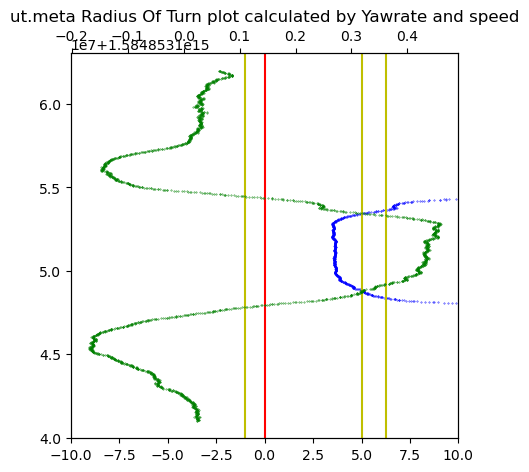

In [191]:
reference_df =load_Speed_and_Yawrate_From_MetaDATA_then_calculate_radius_of_turn_and_plot_with_latAcceleration(ReferenceRoundAbout_5Hz,'sample_ts','IMUYawRate','groundSpeed','IMULatAcceleration')

0        0.020020
1        0.017334
2        0.020752
3        0.018066
4        0.016357
           ...   
16958    0.015625
16959    0.019043
16960    0.018066
16961    0.017334
16962    0.017334
Name: IMUYawRate, Length: 16963, dtype: float64


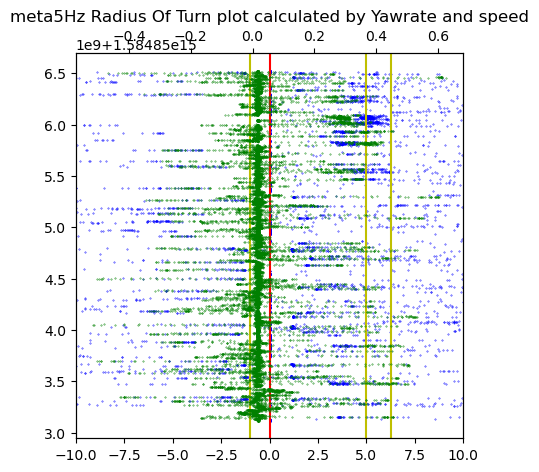

In [192]:
real_df=load_Speed_and_Yawrate_From_MetaDATA_then_calculate_radius_of_turn_and_plot_with_latAcceleration(RoundaboutOriginal_5HZ,'sample_ts','IMUYawRate','groundSpeed','IMULatAcceleration')


-5160061.0

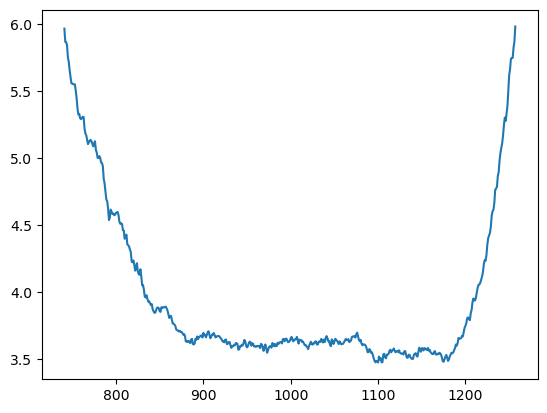

In [193]:
rf_filterd=reference_df[(reference_df['RadiusOfTurn']>0.5) & (reference_df['RadiusOfTurn']<6)]
rf_filterd
rf_filterd['RadiusOfTurn'].plot()
timespan= rf_filterd['sample_ts'].iloc[0]-rf_filterd['sample_ts'].iloc[-1]
timespan

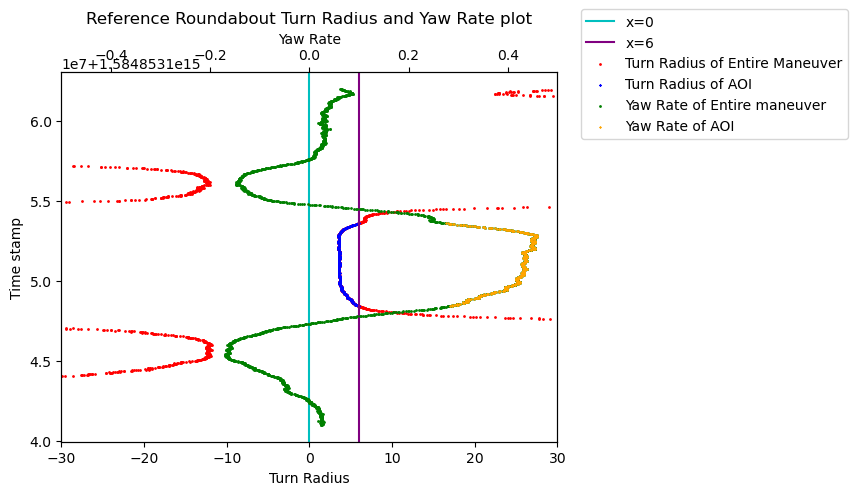

In [299]:

l1=plt.axvline(x=0,color="c")
l2=plt.axvline(x=6,color="purple")
base=plt.subplot(111)
base.set_xlim(-30,30)
l3=base.scatter(x=reference_df['RadiusOfTurn'],y=reference_df['sample_ts'],c='r',s=1,marker="o")
l4=base.scatter(x=rf_filterd['RadiusOfTurn'],y=rf_filterd['sample_ts'],c='b',s=1,marker="x")
secax=base.twiny()
secax.set_xlim(-0.5,0.5)

l5=secax.scatter(x=reference_df['IMUYawRate'],y=reference_df['sample_ts'],c='g',s=1,marker="o")
l6= secax.scatter(x=rf_filterd['IMUYawRate'],y=rf_filterd['sample_ts'],c='orange',s=0.5,marker="x")
secax.set_xlabel("Yaw Rate")
base.set_xlabel('Turn Radius')
base.set_ylabel('Time stamp')
plt.title("Reference Roundabout Turn Radius and Yaw Rate plot")
base.legend((l1,l2,l3,l4,l5,l6),("x=0","x=6","Turn Radius of Entire Maneuver", "Turn Radius of AOI","Yaw Rate of Entire maneuver","Yaw Rate of AOI"), loc='lower right',bbox_to_anchor=(1.6, 0.8))





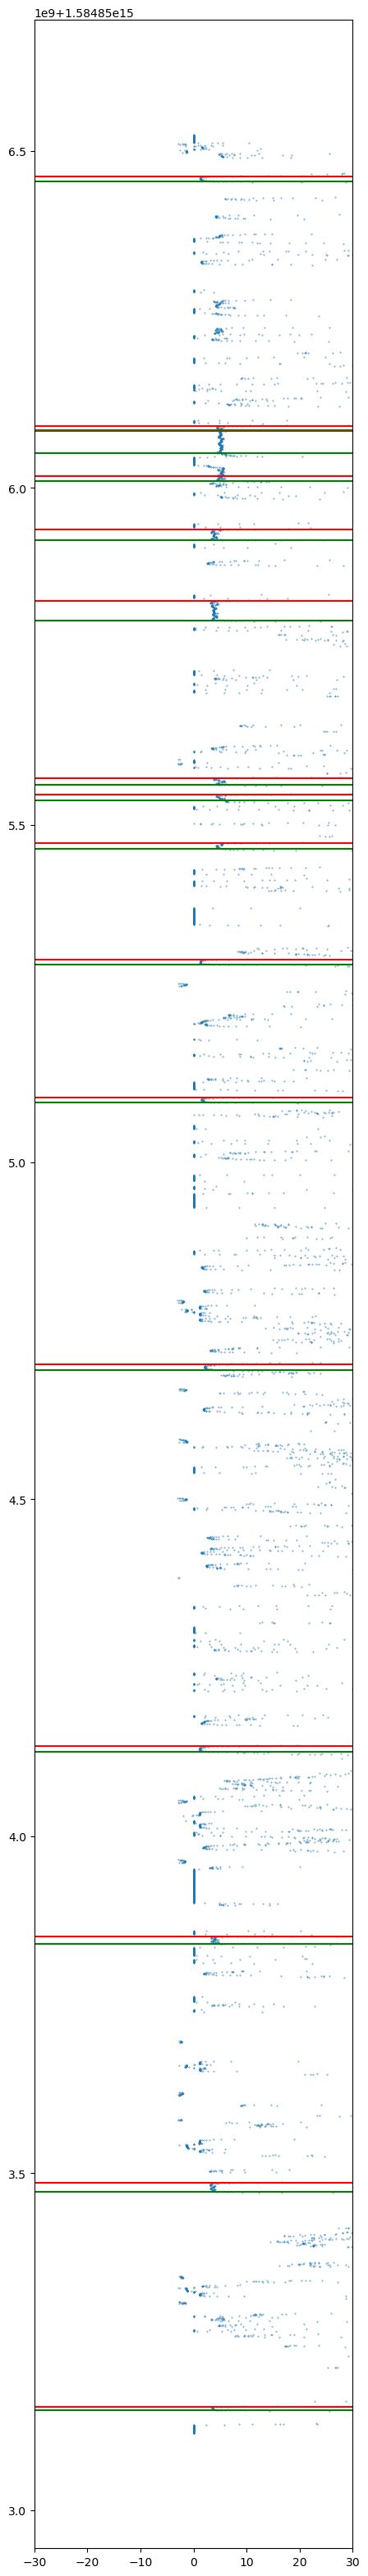

In [301]:
real_filterd2=real_df[(real_df['RadiusOfTurn']>-3)]

last_row_ts=0
ph1=False

periodList=pd.DataFrame(columns=['start','end'])
index=0
for row in real_filterd2.itertuples():
    if (row.RadiusOfTurn>0.5) and (row.RadiusOfTurn<6): 
        if ph1==False:
            ph1=True
            # print('start')
            periodList.at[index,'start']=row.sample_ts
    elif row.RadiusOfTurn>1:
        if ph1==True:
            # print('end')
            periodList.at[index,'end']=row.sample_ts
            index=index+1
            ph1=False
periodList=periodList[(periodList['end']-periodList['start'])>5000000]            
plt.figure(figsize=(5,40))
plt.xlim(-30,30)
plt.scatter(x=real_filterd2['RadiusOfTurn'],y=real_filterd2['sample_ts'],s=0.1)
count=0
result=pd.DataFrame(columns=['start','end'])
for i in periodList.itertuples():
    period=real_filterd2.loc[(real_filterd2['sample_ts']>=i.start) & (real_filterd2['sample_ts']<=i.end)]
    av_Yawrate=period['IMUYawRate'].mean()
    if av_Yawrate>0.28 :
        plt.axhline(i.start,c='g')
        plt.axhline(i.end,c='r')
        result.at[count,'start']=i.start
        result.at[count,'end']=i.end

        count=count+1
result        
result.to_csv(r''+RoundaboutResultPath+'/result.csv', sep=',', index = False)

### Extract AOI roundabout

In [196]:
valid_df = pd.read_csv(RoundaboutResultPath+'/validated_result.csv', sep=',')
print(valid_df)
count=1
for i in valid_df.itertuples():
    period = pd.DataFrame()
    period=real_filterd2.loc[(real_filterd2['sample_ts']>=i.start) & (real_filterd2['sample_ts']<=i.end)]
    period.to_csv(r''+RoundaboutExtractPath+'/extract_roundabout'+str(count)+'.csv', sep=',', index = False)
    count=count+1



          start           end
0  1.584853e+15  1.584853e+15
1  1.584853e+15  1.584853e+15
2  1.584854e+15  1.584854e+15
3  1.584856e+15  1.584856e+15
4  1.584856e+15  1.584856e+15
5  1.584856e+15  1.584856e+15
6  1.584856e+15  1.584856e+15


### provided and identified roundabout

In [198]:
valid_df = pd.read_csv(RoundaboutResultPath+'/validate_provided_roundabout.csv', sep=',')
print(valid_df)
count=1
for i in valid_df.itertuples():
    period = pd.DataFrame()
    period=real_filterd2.loc[(real_filterd2['sample_ts']>=i.start*1000) & (real_filterd2['sample_ts']<=i.end*1000)]
    period.to_csv(r''+RoundaboutProvidedPath+'/reference_roundabout'+str(count)+'.csv', sep=',', index = False)
    count=count+1

           start            end
0  1584853143505  1584853160505
1  1584853463258  1584853491758
2  1584853809710  1584853865861
3  1584855531074  1584855548274
4  1584855786176  1584855851176
5  1584855904227  1584855953327
6  1584855993728  1584856103979


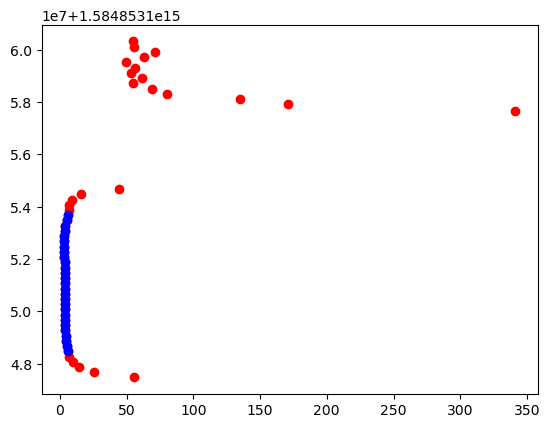

In [199]:
ext1 = pd.read_csv(RoundaboutExtractPath+'/extract_roundabout1.csv', sep=',')
ref1 = pd.read_csv(RoundaboutProvidedPath+'/reference_roundabout1.csv', sep=',')
plt.scatter(x=ref1['RadiusOfTurn'],y=ref1['sample_ts'],c='r')
plt.scatter(x=ext1['RadiusOfTurn'],y=ext1['sample_ts'],c='b')



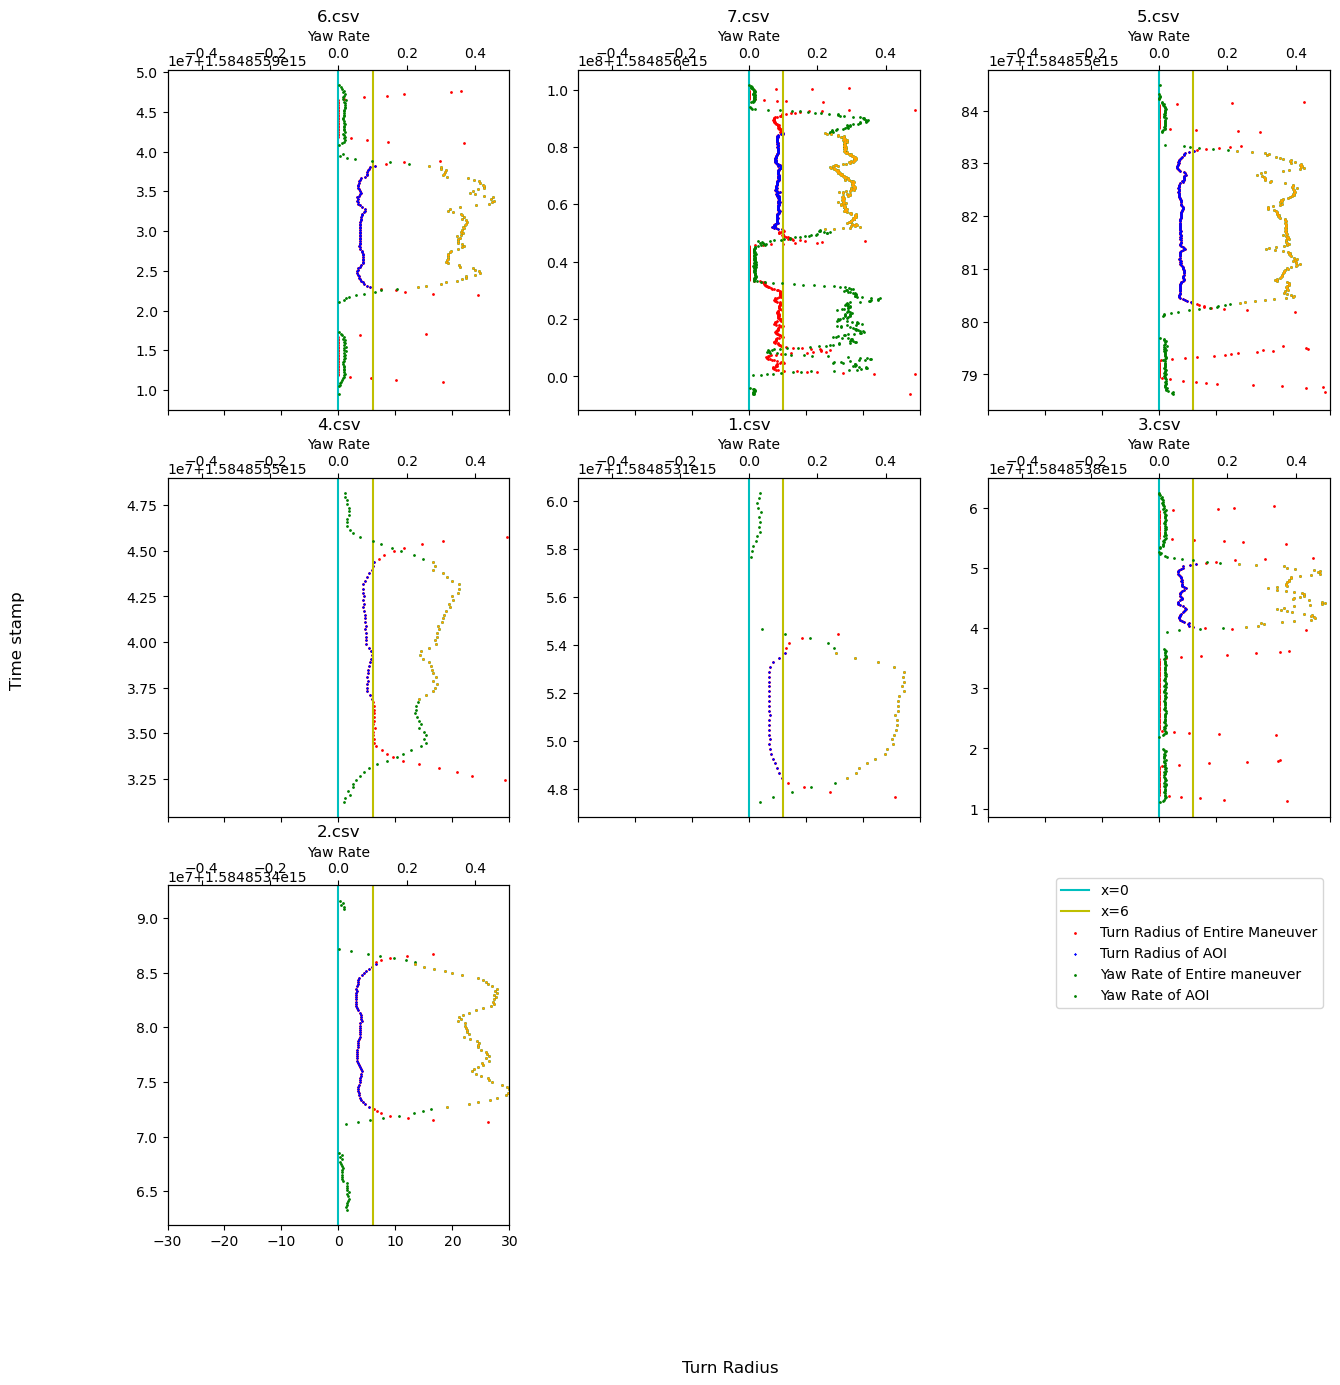

In [213]:
ref_csv_files = glob.glob(os.path.join(RoundaboutProvidedPath, "*.csv"))
extract_csv_files = glob.glob(os.path.join(RoundaboutExtractPath, "*.csv"))
fig,ax = plt.subplots(3,3,figsize=(15, 15),sharex='all')
custom_xlim=(-30,30)
plt.setp(ax, xlim=custom_xlim)
n_col=0
n_row=0
for ref_file in ref_csv_files:
    for ext_file in extract_csv_files:
        if ref_file[-5]== ext_file[-5]:
            ref_df = pd.read_csv(ref_file,sep=',')
            ext_df = pd.read_csv(ext_file,sep=',')
            if len(ref_df)>0:
                l1=ax[n_row,n_col].axvline(x=0,color="c")
                l2=ax[n_row,n_col].axvline(x=6,color="y")
                l3=ax[n_row,n_col].scatter(x=ref_df['RadiusOfTurn'],y=ref_df['sample_ts'],c='r',s=1,marker="o")
                l4=ax[n_row,n_col].scatter(x=ext_df['RadiusOfTurn'],y=ext_df['sample_ts'],c='b',s=0.5,marker="x")
                secax=ax[n_row,n_col].twiny()
                secax.set_xlim(-0.5,0.5)
                secax.set_xlabel('Yaw Rate')
                l5=secax.scatter(x=ref_df['IMUYawRate'],y=ref_df['sample_ts'],c='g',s=1,marker="o")
                l6=secax.scatter(x=ext_df['IMUYawRate'],y=ext_df['sample_ts'],c='orange',s=0.5,marker="x")
                ax[n_row,n_col].set_title(ref_file[-5:])
                n_col=n_col+1
                if n_col==3:
                    n_col=0
                    n_row=n_row+1
fig.delaxes(ax[2][2])
fig.delaxes(ax[2][1])
fig.supxlabel('Turn Radius')
fig.supylabel('Time stamp')

fig.legend((l1,l2,l3,l4,l5,l6),("x=0","x=6","Turn Radius of Entire Maneuver", "Turn Radius of AOI","Yaw Rate of Entire maneuver","Yaw Rate of AOI"), loc='lower right',bbox_to_anchor=(0.9, 0.25))



        

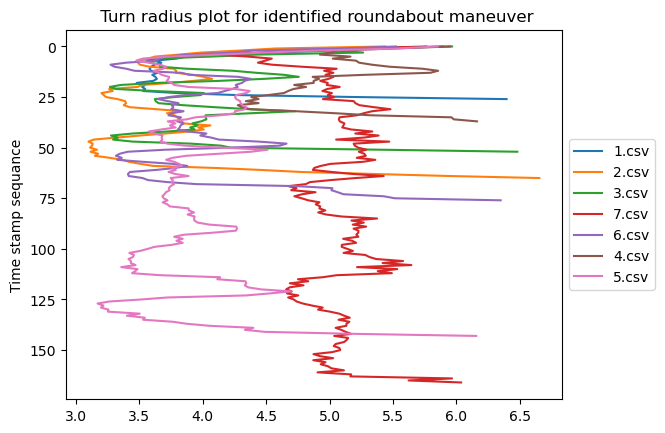

In [302]:
extract_csv_files = glob.glob(os.path.join(RoundaboutExtractPath, "*.csv")) 

for file in extract_csv_files:
        df = pd.read_csv(file, sep=',', usecols = ['sample_ts','RadiusOfTurn','IMUYawRate','Speed'])
        df=df.dropna()
        data=df.reset_index()
        plt.plot(data['RadiusOfTurn'],data.index,label=str(file[-5:]))
        data["IMUYawRate"].describe()
        data["Speed"].describe()

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Time stamp sequance')
plt.title(" Turn radius plot for identified roundabout maneuver")
# plt.xlabel("Turn Radius")
plt.gca().invert_yaxis()

## Normalization algorithm

Version 1:

In [222]:
def add_empty_rows(df, n_empty, period):
    """ adds 'n_empty' empty rows every 'period' rows  to 'df'. 
        Returns a new DataFrame. """
    
    # to make sure that the DataFrame index is a RangeIndex(start=0, stop=len(df)) 
    # and that the original df object is not mutated. 
    df = df.reset_index(drop=True)
    
    # length of the new DataFrame containing the NaN rows
    len_new_index = len(df) + n_empty*(len(df) // period)
    # index of the new DataFrame
    new_index = pd.RangeIndex(len_new_index)
    
    # add an offset (= number of NaN rows up to that row) 
    # to the current df.index to align with new_index. 
    df.index += n_empty * (df.index
                             .to_series()
                             .groupby(df.index // period)
                             .ngroup())
    
    # reindex by aligning df.index with new_index. 
    # Values of new_index not present in df.index are filled with NaN.
    new_df = df.reindex(new_index)
    
    return new_df
# reference: https://stackoverflow.com/questions/14399689/matplotlib-drawing-lines-between-points-ignoring-missing-data

In [221]:
def GCD(a, b):
    if b == 0:
        return a
    return GCD(b, a % b)

In [ ]:
def load_All_LaneChange_In_Subfolder_Then_Select_With_Thresholds_And_Normalize_And_Plot(filePath,key,ts_key,threshold1,threshold2,offset1=0,offset2=0,target_size=100):
    csv_files = glob.glob(os.path.join(filePath, "*.csv"))

    for file in csv_files:
        df = pd.read_csv(file, sep=';', usecols = [ts_key,key])
        df=df.dropna()
        result= df.query("{0} > @threshold1 or {0} < @threshold2".format(key))
        start_index=result.index[0]+offset1
        end_index=result.index[-1]+offset2
        data=df[start_index:end_index].reset_index()
        
        if len(data)>target_size:
            return 'Your original data have a size of '+str(len(data))+', which is larger then the target_size '+ str(target_size)+'Please choose another target_size'
        missing_data_count=target_size-data.shape[0]
        gcd=GCD(round(missing_data_count/10),round(len(data)/10))
        data=add_empty_rows(data,round(missing_data_count/10)/gcd,round(len(data)/10)/gcd)
        data=data.reindex(index=range(target_size))
        data=data.dropna()
        plt.plot(data[key],data.index,label=str(file))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().invert_yaxis()

In [ ]:
def load_All_LaneChange_In_Subfolder_Then_Select_With_Thresholds_And_Normalize_And_Encode_as_Morton_and_plot(filePath,key1,key2,normalize_key,ts_key,threshold1,threshold2,sfc_offset1,sfc_offset2,sfc_multiplier1,sfc_multiplier2,plot_row,plot_column,dataset_offset1=0,dataset_offset2=0,target_size=100 ):
    """key1 is by default """
    csv_files = glob.glob(os.path.join(filePath, "*.csv"))
    fig, ax = plt.subplots(plot_row,plot_column,figsize=(15, 15),sharex='all')   
    fig.suptitle(filePath, fontsize=16)
 
    fig.tight_layout(pad=4.0)
    row_position = 0
    column_position=0
    for file in csv_files:
        df = pd.read_csv(file, sep=';', usecols = [ts_key,key1,key2])
        df=df.dropna()
        if(normalize_key != key1 and normalize_key!=key2):
            print('You are using a normalize key different from key1 or key2, please choose the right key to continue!')
            return
        result= df.query("{0} > @threshold1 or {0} < @threshold2".format(normalize_key))
        start_index=result.index[0]+dataset_offset1
        end_index=result.index[-1]+dataset_offset2
        data=df[start_index:end_index].reset_index()

        if len(data)>target_size:
            print( 'Your original data have a size of '+str(len(data))+', which is larger then the target_size '+ str(target_size)+'Please choose another target_size')
            return
        missing_data_count=target_size-data.shape[0]
        gcd=GCD(round(missing_data_count/10),round(len(data)/10))
        data=add_empty_rows(data,round(missing_data_count/10)/gcd,round(len(data)/10)/gcd)
        data=data.reindex(index=range(target_size))
        data=data.dropna()
        data[key1+'modified']=data[key1].add(sfc_offset1)
        data[key2+'modified']=data[key2].add(sfc_offset2)
        data[key1+'modified']=data[key1+'modified'].multiply(sfc_multiplier1)
        data[key2+'modified']=data[key2+'modified'].multiply(sfc_multiplier2)
        # print(data)
        data['morton']=data.apply(set_value,args=(key1+'modified',key2+'modified'),axis=1)
        ax[row_position,column_position].scatter(x=data['morton'],y=data.index,c='red',s=5)
        ax[row_position,column_position].set_title(file[-5:])
        ax[row_position,column_position].invert_yaxis()
        column_position=column_position+1
        if column_position==plot_column:
            column_position=0
            row_position=row_position+1
        
        

In [ ]:
def load_All_Files_In_Subfolder_Then_Select_With_Thresholds_And_Normalize_And_Plot_Corr(filePath,normalize_key,ts_key,threshold1,threshold2,dataset_offset1=0,dataset_offset2=0,target_size=100):
    """key1 is by default """
    csv_files = glob.glob(os.path.join(filePath, "*.csv"))
    cor=pd.DataFrame()
    for file in csv_files:
        df = pd.read_csv(file, sep=';', usecols = [ts_key,normalize_key])
        df=df.dropna()
        result= df.query("{0} > @threshold1 or {0} < @threshold2".format(normalize_key))
        start_index=result.index[0]+dataset_offset1
        end_index=result.index[-1]+dataset_offset2
        data=df[start_index:end_index].reset_index()
        missing_data_count=target_size-data.shape[0]
        gcd=GCD(round(missing_data_count/10),round(len(data)/10))
        data=add_empty_rows(data,round(missing_data_count/10)/gcd,round(len(data)/10)/gcd)
        data=data.reindex(index=range(target_size))
        data=data.dropna()
        
        cor[file[-5:]]=data[normalize_key]
    # print(cor)
    corr=cor.corr()
    # corelation.style.background_gradient(cmap='coolwarm')
    # plt.matshow(corelation)
    # sb.heatmap(corr,annot=True)
    cov=cor.cov()

    fig, (ax1, ax2) = plt.subplots(2,1)
    sb.heatmap(corr,annot=True,ax=ax1)
    sb.heatmap(cov,annot=True,ax=ax2)


Version 2:

In [220]:
def resizeWithOutCarriedValue(data,N):
    M=len(data)
    res=pd.DataFrame(np.nan, columns=data.columns,index=range(N))
    for n in range(N):
        pos=int(n*M/N)
        if M>=N:
            res.iloc[n] = data.iloc[pos]
        elif ((int((n-1)*M/N)!= pos) or n== 0):
            res.iloc[n] = data.iloc[pos]
    return res

In [217]:
def load_All_Files_In_Subfolder_Then_Select_With_Thresholds_And_Normalize_And_Plot(filePath,key,ts_key,threshold1,threshold2,offset1=0,offset2=0,target_size=100):
    csv_files = glob.glob(os.path.join(filePath, "*.csv"))
    benchmark=pd.DataFrame()

    for file in csv_files:
        df = pd.read_csv(file, sep=';', usecols = [ts_key,key])
        df=df.dropna()
        result= df.query("{0} > @threshold1 or {0} < @threshold2".format(key))
        start_index=result.index[0]+offset1
        end_index=result.index[-1]+offset2
        data=df[start_index:end_index].reset_index()

        data = resizeWithOutCarriedValue(data,target_size)

        data=data.dropna()
        plt.plot(data[key],data.index,label=str(file[-5:]))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('Time stamp sequance')
    plt.xlabel('IMU lateral acceleration')
    plt.gca().invert_yaxis()

In [304]:
def benchmark_v2_withCor(filePath,ts_key,key,pos,seps=",",target_size=100):
    csv_files = glob.glob(os.path.join(filePath, "*.csv"))
    benchmark=pd.DataFrame()
    cor = pd.DataFrame()
    for file in csv_files:
        df = pd.read_csv(file, sep=seps, usecols = [ts_key,key])
        data=df.reset_index()
        t_start=time()
        data = resizeWithOutCarriedValue(data,target_size)
        t_end=time()
        t= [t_end-t_start]
        benchmark[file[pos:pos+1]]=t
        cor[file[pos:pos+1]]=data[key]
    corr=cor.corr()    
    sb.heatmap(corr,annot=True).set(title='corraltion between lane change with Ver. 2, taget size ='+str(target_size))
    return benchmark

In [303]:
def benchmark_v1_withCor(filePath,ts_key,key,pos,seps=",",target_size=100):
    csv_files = glob.glob(os.path.join(filePath, "*.csv"))
    benchmark=pd.DataFrame()
    cor = pd.DataFrame()
    for file in csv_files:
        df = pd.read_csv(file, sep=seps, usecols = [ts_key,key])
        data=df.reset_index()
        if len(data)>target_size:
            return 'Your original data have a size of '+str(len(data))+', which is larger then the target_size '+ str(target_size)+'Please choose another target_size'
        t_start=time()
        missing_data_count=target_size-data.shape[0]
        gcd=GCD(round(missing_data_count/10),round(len(data)/10))
        data=add_empty_rows(data,round(missing_data_count/10)/gcd,round(len(data)/10)/gcd)
        data=data.reindex(index=range(target_size))
        data=data.dropna()
        t_end=time()
        t= [t_end-t_start]
        benchmark[file[pos:pos+1]]=t
        cor[file[pos:pos+1]]=data[key]
    corr=cor.corr()
    sb.heatmap(corr,annot=True).set(title='corraltion between lane change with Ver. 1, taget size ='+str(target_size))
    return benchmark

## Compare between v1 and v2.

          6         1         7         9         8         5         2   
0  0.001248  0.000903  0.001092  0.001101  0.000922  0.000773  0.000717  \

          3         4  
0  0.000738  0.000887  


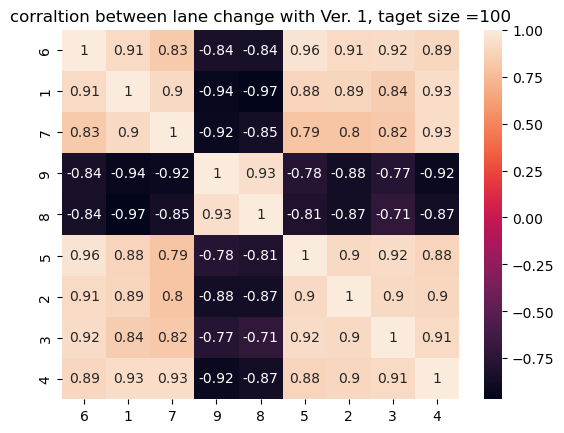

In [305]:
v1_benchmark= benchmark_v1_withCor(LaneChangeExtractPath,"ts","accel_trans",-14,";",target_size=100)
print(v1_benchmark)

          6         1         7         9         8         5         2   
0  0.002644  0.002646  0.002091  0.001679  0.001855  0.002607  0.002162  \

          3         4  
0  0.002774  0.001969  


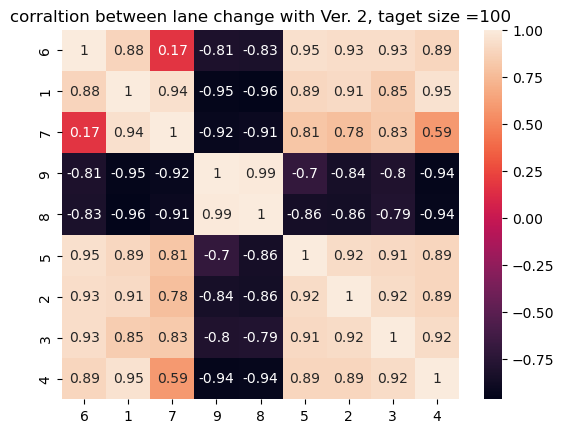

In [306]:
v2_benchmark= benchmark_v2_withCor(LaneChangeExtractPath,"ts","accel_trans",-14,";",target_size=100)
print(v2_benchmark)

,6,1,7,9,8,5,2,3,4
0,0.00107,0.001114,0.000953,0.000913,0.000916,0.000864,0.000849,0.000845,0.000861


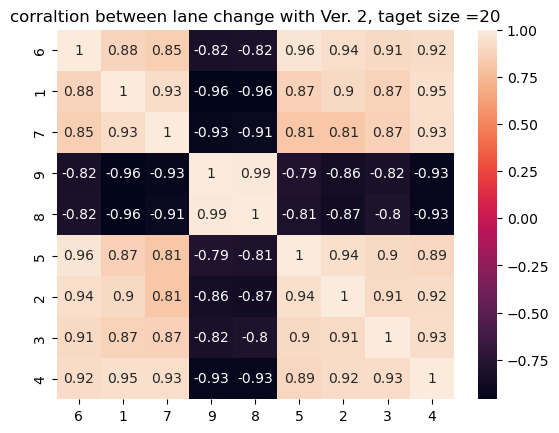

In [307]:
v2_benchmark= benchmark_v2_withCor(LaneChangeExtractPath,"ts","accel_trans",-14,";",target_size=20)
v2_benchmark

## Benchmark and compare with DTW

In [309]:
lc1= pd.read_csv("./Data/LaneChange/extract/lane_change_1extracted.csv",sep=";")
lc2= pd.read_csv("./Data/LaneChange/extract/lane_change_2extracted.csv",sep=";")

In [318]:
align=dtw.dtw(lc1["accel_trans"], lc2["accel_trans"], keep_internals=True)

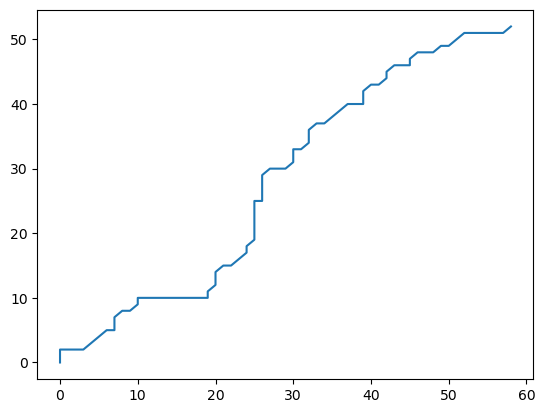

In [320]:
plt.plot(align.index1, align.index2)

0.9060590203150657

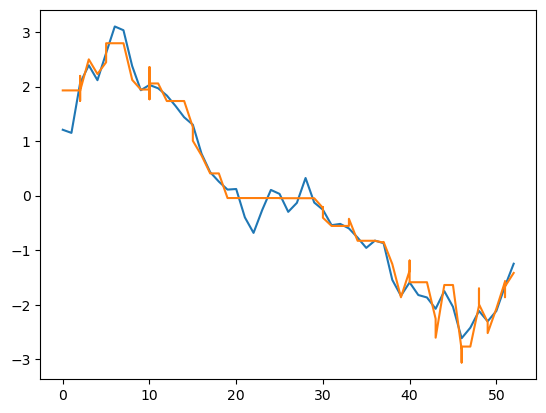

In [322]:
plt.plot(lc2['accel_trans'])
plt.plot(align.index2,lc1['accel_trans'].iloc[align.index1])  
cor=lc2['accel_trans'].corr(lc1['accel_trans'].iloc[align.index1])
cor

87
87


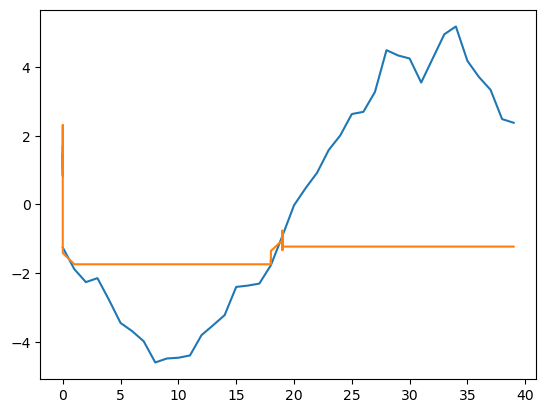

In [337]:
lc7= pd.read_csv("./Data/LaneChange/extract/lane_change_7extracted.csv",sep=";")
lc9= pd.read_csv("./Data/LaneChange/extract/lane_change_9extracted.csv",sep=";")
align2=dtw.dtw(lc7["accel_trans"],lc9["accel_trans"],keep_internals=True)
plt.plot(lc9["accel_trans"])  
plt.plot(align2.index2,lc7['accel_trans'].iloc[align2.index1]) 
cor=lc9['accel_trans'].corr(lc7['accel_trans'].iloc[align2.index1])
cor
print(len(align2.index1))
print(len(align2.index2))


87
87


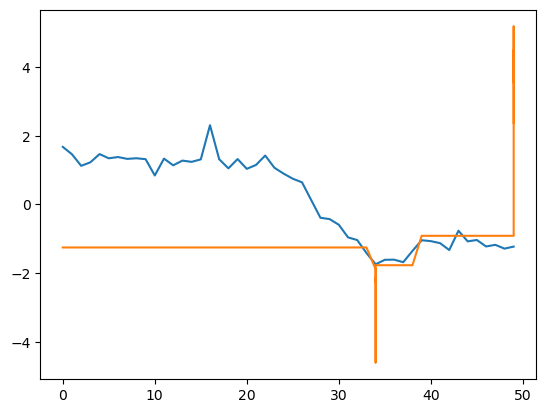

In [336]:
align3=dtw.dtw(lc9["accel_trans"],lc7["accel_trans"],keep_internals=True)
plt.plot(lc7["accel_trans"])  
plt.plot(align3.index2,lc9['accel_trans'].iloc[align3.index1]) 
cor3=lc7['accel_trans'].corr(lc9['accel_trans'].iloc[align3.index1])
cor3
print(len(align3.index1))
print(len(align3.index2))


In [ ]:
def dtw_normalization(filePath,pos,key,sep):
    csv_files = glob.glob(os.path.join(filePath, "*.csv"))
    benchmark=pd.DataFrame()
    cor = pd.DataFrame()
    for a_file in csv_files:
        for b_file in csv_files:
            df_a=pd.read_csv(a_file,sep=sep,usecols=[key])
                        df_a=pd.read_csv(a_file,sep=sep,usecols=[key])

            align = dtw.dtw(a_file,b_file)
            cor[a_file[pos:pos+1],b_file[pos:pos+1]]= 
            cor=lc9['accel_trans'].corr(lc7['accel_trans'].iloc[align2.index1])

            